<a href="https://colab.research.google.com/github/kerker83/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
import numpy as np
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/Colab Notebooks'
input_images = data_dir + "/full_numpy_bitmap_basketball.npy"

data = np.load(input_images)

In [ ]:
data.shape

(133793, 784)

## Data Visualization

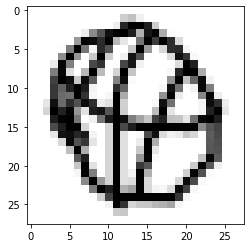

In [ ]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w, img_h = data.shape[1:3]

plt.imshow(data[2001,:,:,0], cmap='Greys')

## Discriminator

In [ ]:
def build_discriminator(depth=64, p=0.4):
  
  # define input
  image = Input((img_w,img_h,1))

  # convolution layer
  conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
  conv1 = Dropout(p)(conv1)

  conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
  conv2 = Dropout(p)(conv2)

  conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
  conv3 = Dropout(p)(conv3)

  conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))

  # output layer
  prediction = Dense(1, activation='sigmoid')(conv4)

  # define model
  model = Model(inputs=image, outputs=prediction)

  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0008,decay=6e-8,clipvalue=1.0), metrics=['accuracy'])

## Generator

In [ ]:
z_dimensions = 32

def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):

  # define input
  noise = Input((latent_dim,))

  # the first dense layer
  dense1 = Dense(7*7*depth)(noise)
  dense1 = BatchNormalization(momentum=0.9)(dense1)
  dense1 = Activation(activation='relu')(dense1)
  dense1 = Reshape((7,7,depth))(dense1)
  dense1 = Dropout(p)(dense1)

  # de-convolutional layer
  conv1 = UpSampling2D()(dense1)
  conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
  conv1 = BatchNormalization(momentum=0.9)(conv1)
  conv1 = Activation(activation='relu')(conv1)

  conv2 = UpSampling2D()(conv1)
  conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
  conv2 = BatchNormalization(momentum=0.9)(conv2)
  conv2 = Activation(activation='relu')(conv2)

  conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
  conv3 = BatchNormalization(momentum=0.9)(conv3)
  conv3 = Activation(activation='relu')(conv3)

  # output layer
  image = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

  # define model
  model = Model(inputs=noise, outputs=image)

  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

In [ ]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

In [ ]:
adversarial_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0004, decay=3e-8, clipvalue=1.0), metrics=['accuracy'])

In [ ]:
def train(train_round=2000, batch=128, z_dim=z_dimensions):

  d_metrics = []
  a_metrics = []

  running_d_loss = 0
  running_d_acc = 0
  running_a_loss = 0
  running_a_acc = 0

  for i in range(train_round):

    # sampling from real images set
    real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))

    # generate fake images
    fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))

    # concatenate real and fake images
    x = np.concatenate((real_imgs, fake_imgs))

    # label y for discriminator
    y = np.ones([2*batch,1])
    y[batch:,:] = 0

    # train the discriminator
    d_metrics.append(discriminator.train_on_batch(x,y))
    running_d_loss += d_metrics[-1][0]
    running_d_acc += d_metrics[-1][1]

    # set the noise and label y for the generator
    noise = np.random.uniform(-1.0,1.0,size=[batch, z_dim])
    y = np.ones([batch,1])

    # train the generator
    a_metrics.append(adversarial_model.train_on_batch(noise, y))
    running_a_loss += a_metrics[-1][0]
    running_a_acc += a_metrics[-1][1]

    # show the process and generate images
    if (i+1)%100 == 0:
      print('train_round #{}'.format(i))
      log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
      log_mesg = "%s: [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
      print(log_mesg)

      noise = np.random.uniform(-1.0,1.0,size=[16, z_dim])
      gen_imgs = generator.predict(noise)
      plt.figure(figsize=(5,5))

      for k in range(gen_imgs.shape[0]):
        plt.subplot(4,4,k+1)
        plt.imshow(gen_imgs[k,:,:,0],cmap='gray')
        plt.axis('off')

      plt.tight_layout()
      plt.show()

  return a_metrics, d_metrics

## Training

train_round #99
99: [D loss: 0.296705, acc: 0.947483]: [A loss: 2.313115, acc: 0.297743]


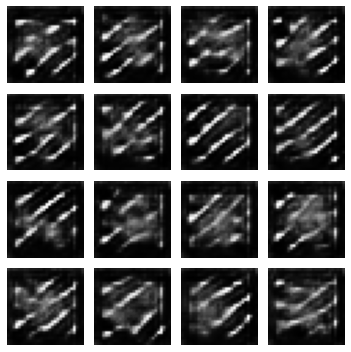

train_round #199
199: [D loss: 0.269533, acc: 0.927980]: [A loss: 3.221264, acc: 0.188207]


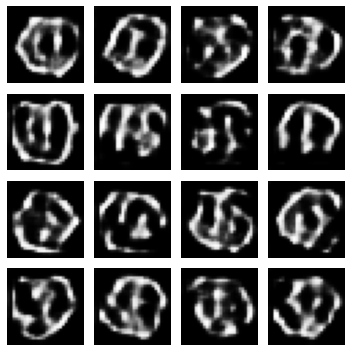

train_round #299
299: [D loss: 0.288128, acc: 0.912599]: [A loss: 3.088625, acc: 0.154499]


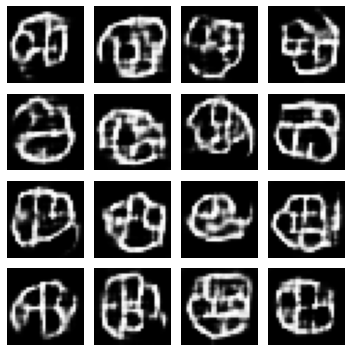

train_round #399
399: [D loss: 0.306055, acc: 0.894512]: [A loss: 2.916571, acc: 0.147909]


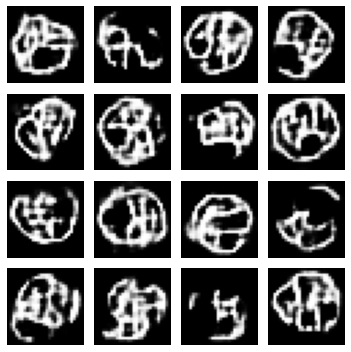

train_round #499
499: [D loss: 0.307912, acc: 0.888504]: [A loss: 2.833282, acc: 0.137087]


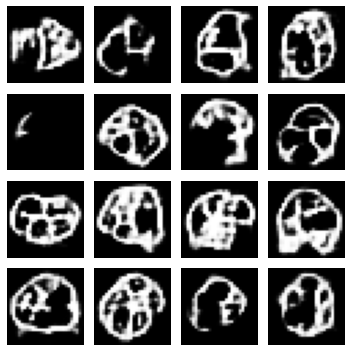

train_round #599
599: [D loss: 0.302649, acc: 0.887971]: [A loss: 2.815075, acc: 0.126096]


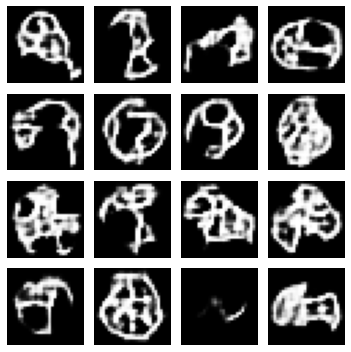

train_round #699
699: [D loss: 0.294108, acc: 0.889625]: [A loss: 2.846942, acc: 0.116394]


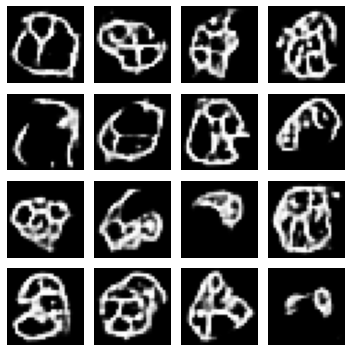

train_round #799
799: [D loss: 0.284930, acc: 0.892434]: [A loss: 2.902241, acc: 0.107811]


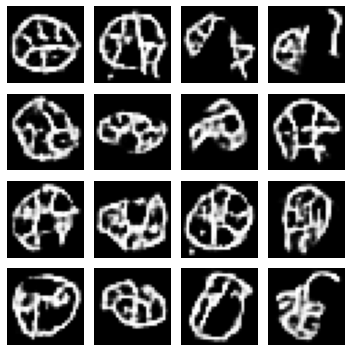

train_round #899
899: [D loss: 0.276160, acc: 0.895326]: [A loss: 2.951614, acc: 0.100294]


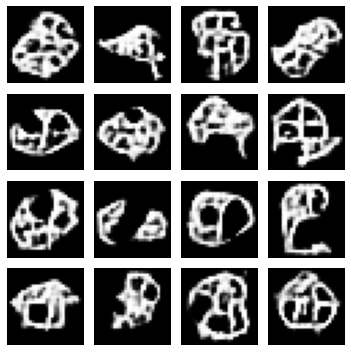

train_round #999
999: [D loss: 0.267452, acc: 0.898496]: [A loss: 3.008224, acc: 0.093938]


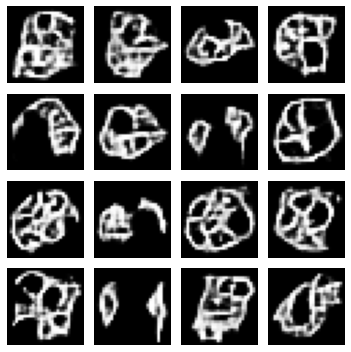

train_round #1099
1099: [D loss: 0.259223, acc: 0.901629]: [A loss: 3.058261, acc: 0.087935]


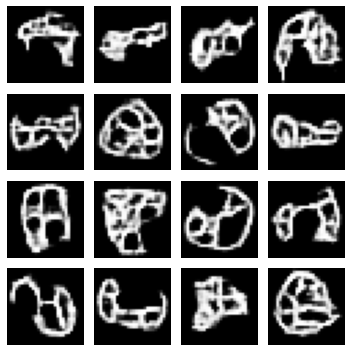

train_round #1199
1199: [D loss: 0.252464, acc: 0.904139]: [A loss: 3.096923, acc: 0.083084]


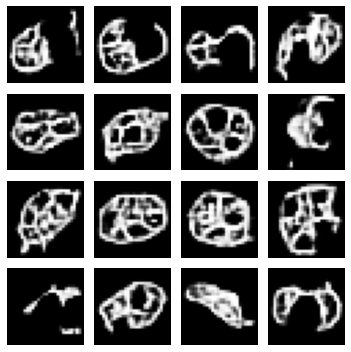

train_round #1299
1299: [D loss: 0.245319, acc: 0.906924]: [A loss: 3.140336, acc: 0.078865]


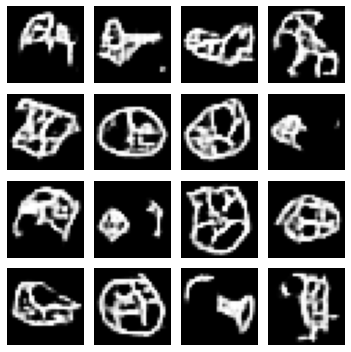

train_round #1399
1399: [D loss: 0.239126, acc: 0.909341]: [A loss: 3.186991, acc: 0.075160]


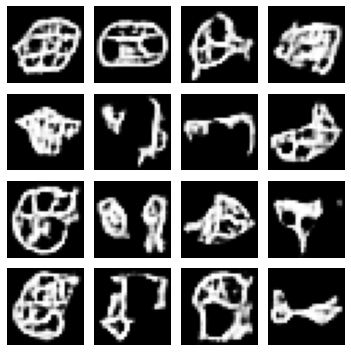

train_round #1499
1499: [D loss: 0.233176, acc: 0.911722]: [A loss: 3.227391, acc: 0.072022]


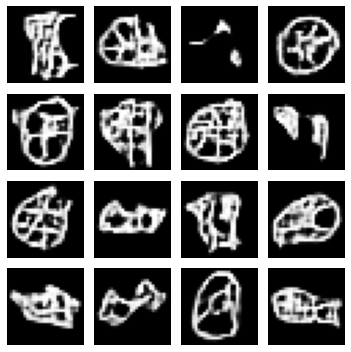

train_round #1599
1599: [D loss: 0.228416, acc: 0.913623]: [A loss: 3.269404, acc: 0.069223]


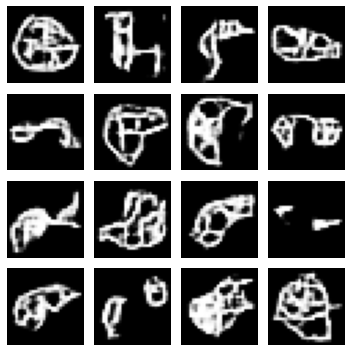

train_round #1699
1699: [D loss: 0.223138, acc: 0.915683]: [A loss: 3.310270, acc: 0.066491]


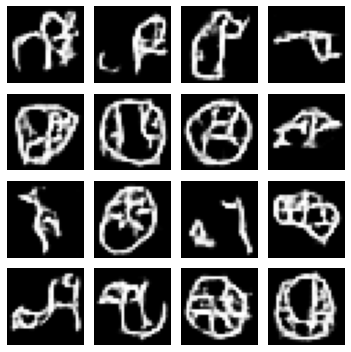

train_round #1799
1799: [D loss: 0.219000, acc: 0.917382]: [A loss: 3.341144, acc: 0.064324]


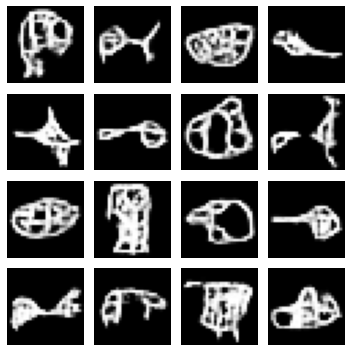

train_round #1899
1899: [D loss: 0.214943, acc: 0.918958]: [A loss: 3.375306, acc: 0.062405]


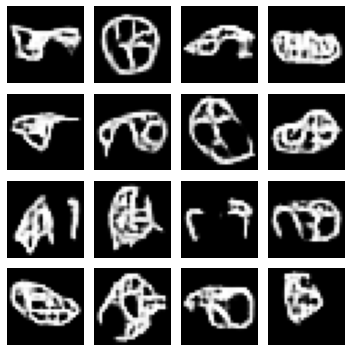

train_round #1999
1999: [D loss: 0.211383, acc: 0.920376]: [A loss: 3.403599, acc: 0.060550]


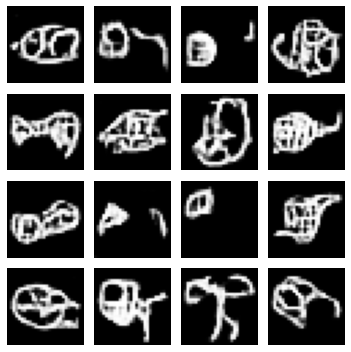

In [ ]:
# train GAN
a_metrics_complete, d_metrics_complete = train()